In [1]:
import os
import pandas as pd
import numpy as np
import re
import ast
import json
DATA_DIR = '../../data/CoT_data/'
storage_dir = os.path.join(DATA_DIR, 'new_extracted_data')
file_store_path = os.path.join(storage_dir, 'final_extracted_train.json')
import sys
sys.path.insert(0, '../')
from utils import *

from CS_based_early_stopping import trained_LR_model, CS_early_stopping,trained_RF_model,trained_NB_model
import itertools
from itertools import combinations




df = pd.read_json(file_store_path, lines=True)
# List of values to exclude
exclude_list = ['ruin_names', 'tracking_three', 'BigBench','strategy_qa']

# Filter the DataFrame
filtered_df = df[~df['Name'].str.contains('|'.join(exclude_list), case=False, na=False)]
df = filtered_df

# to do: if we will use supervised learning model, need to run other experiments like other Supervised learning model

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df.shape

(16725, 25)

In [40]:
df.shape

(7332, 25)

In [2]:
feature_li = ['LEN', 'QUA_IM', 'SIM_COT_BIGRAM', 'SIM_COT_AGG', 'SIM_AC_BIGRAM', 'SIM_AC_AGG', 'SIM_INPUT', 'STEP_COUNT', 'STEP_COHERENCE']

In [71]:
df_flat = prepare_df(df, feature_li)
df_flat.head()

,LEN,QUA_IM,SIM_COT_BIGRAM,SIM_COT_AGG,SIM_AC_BIGRAM,SIM_AC_AGG,SIM_INPUT,STEP_COUNT,STEP_COHERENCE,Correctness
0,1,0,0.500000,0.500000,0,0,0.279412,5,0.474774,0
1,1,0,0.836735,0.836735,0,0,0.318841,5,0.414564,0
2,1,0,0.854167,0.857143,0,1,0.289855,5,0.450225,0
3,1,0,0.625000,0.585714,0,0,0.318841,5,0.414564,0
4,1,0,0.608696,0.700000,1,0,0.318841,5,0.414564,0


## Preliminary Study： Preliminary Feature Analysis

In [72]:
df_flat 

,LEN,QUA_IM,SIM_COT_BIGRAM,SIM_COT_AGG,SIM_AC_BIGRAM,SIM_AC_AGG,SIM_INPUT,STEP_COUNT,STEP_COHERENCE,Correctness
0,1,0,0.500000,0.500000,0,0,0.279412,5,0.474774,0
1,1,0,0.836735,0.836735,0,0,0.318841,5,0.414564,0
2,1,0,0.854167,0.857143,0,1,0.289855,5,0.450225,0
3,1,0,0.625000,0.585714,0,0,0.318841,5,0.414564,0
4,1,0,0.608696,0.700000,1,0,0.318841,5,0.414564,0
...,...,...,...,...,...,...,...,...,...,...
1101955,0,0,0.863636,0.381818,0,0,0.407407,0,0.000000,0
1101956,0,0,0.875000,0.436364,0,0,0.343750,0,0.000000,0
1101957,0,0,0.875000,0.381818,0,0,0.387097,0,0.000000,0
1101958,0,0,1.000000,0.381818,0,0,0.407407,0,0.000000,0


Correlations with Correctness:
LEN              -0.086057
QUA_IM           -0.049183
SIM_COT_BIGRAM    0.053008
SIM_COT_AGG       0.085048
SIM_AC_BIGRAM     0.367268
SIM_AC_AGG        0.402660
SIM_INPUT        -0.042267
STEP_COUNT       -0.047642
STEP_COHERENCE   -0.026442
Name: Correctness, dtype: float64


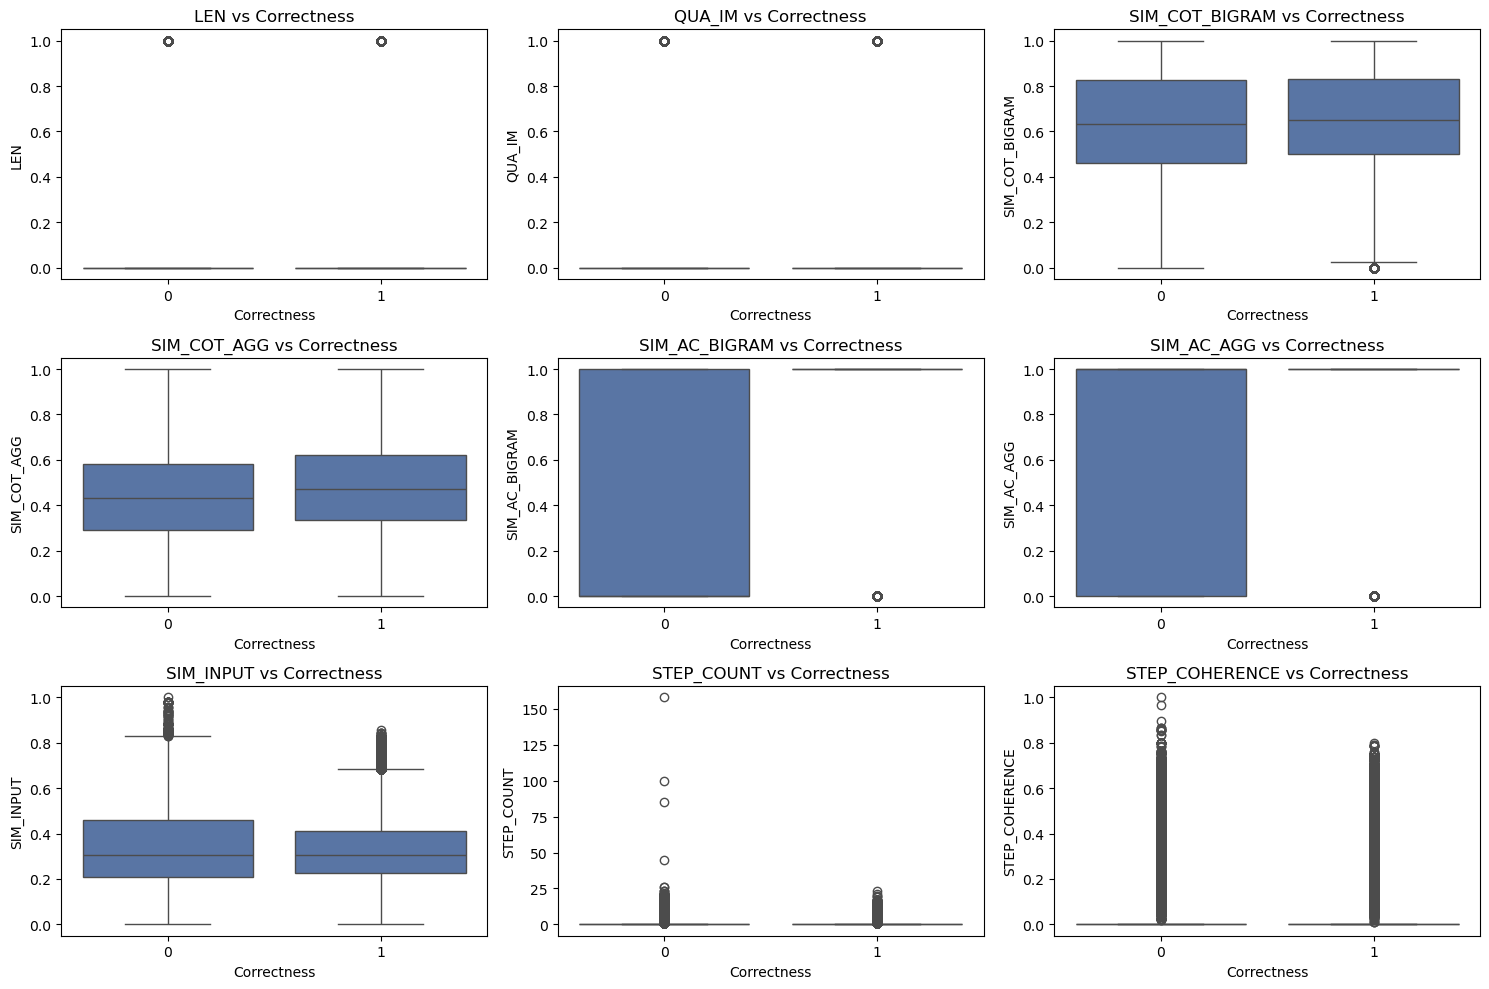

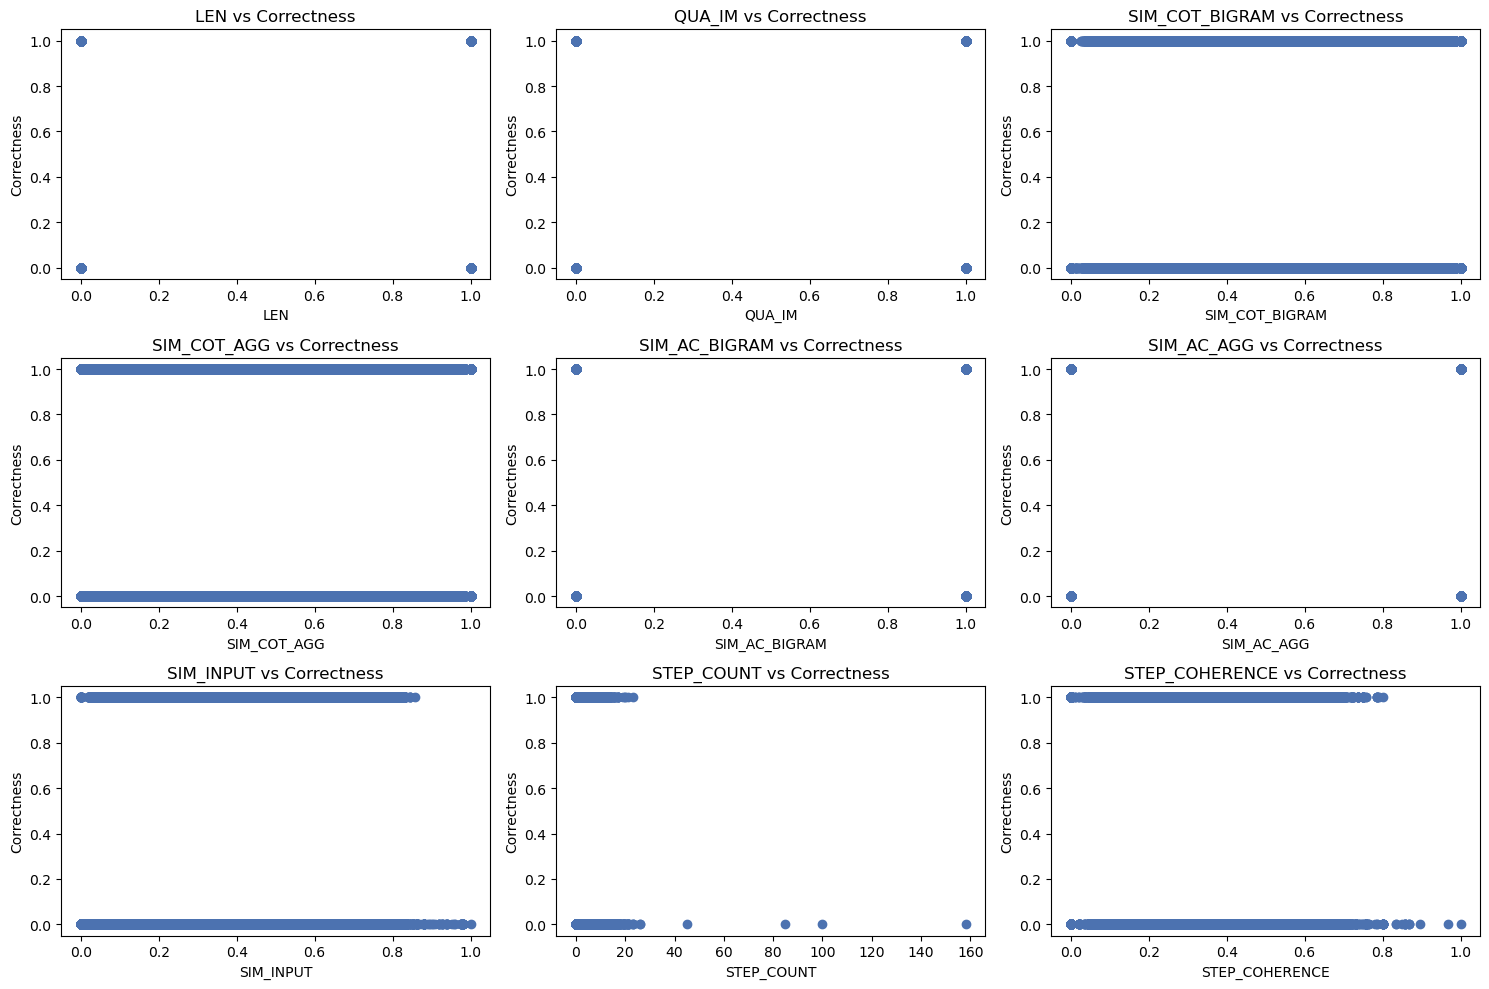

LEN: t-statistic = -90.67382151633001, p-value = 0.0
QUA_IM: t-statistic = -51.69229108328953, p-value = 0.0
SIM_COT_BIGRAM: t-statistic = 55.72317747087016, p-value = 0.0
SIM_COT_AGG: t-statistic = 89.60336878575164, p-value = 0.0
SIM_AC_BIGRAM: t-statistic = 414.50384198855454, p-value = 0.0
SIM_AC_AGG: t-statistic = 461.7782741069284, p-value = 0.0
SIM_INPUT: t-statistic = -44.40938189757156, p-value = 0.0
STEP_COUNT: t-statistic = -50.06838112751307, p-value = 0.0
STEP_COHERENCE: t-statistic = -27.76677246609537, p-value = 1.251414385541157e-169


In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Assume df_flat is already loaded

# 1. Correlation Analysis
correlations = df_flat.corr()['Correctness'].drop('Correctness')
print("Correlations with Correctness:")
print(correlations)

# 2. Distribution Visualization
plt.figure(figsize=(15, 10))
for i, column in enumerate(df_flat.columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='Correctness', y=column, data=df_flat)
    plt.title(f'{column} vs Correctness')
plt.tight_layout()
plt.show()

# 3. Scatter Plots
plt.figure(figsize=(15, 10))
for i, column in enumerate(df_flat.columns[:-1], 1):
    plt.subplot(3, 3, i)
    plt.scatter(df_flat[column], df_flat['Correctness'])
    plt.xlabel(column)
    plt.ylabel('Correctness')
    plt.title(f'{column} vs Correctness')
plt.tight_layout()
plt.show()

# 4. Statistical Tests
for column in df_flat.columns[:-1]:
    correct = df_flat[df_flat['Correctness'] == 1][column]
    incorrect = df_flat[df_flat['Correctness'] == 0][column]
    t_stat, p_value = stats.ttest_ind(correct, incorrect)
    print(f"{column}: t-statistic = {t_stat}, p-value = {p_value}")


## Abalation 2: Individual Impact of Reasoning-Level and Answer-Level Features

,LEN,QUA_IM,SIM_COT_BIGRAM,SIM_COT_AGG,SIM_AC_BIGRAM,SIM_AC_AGG,SIM_INPUT,STEP_COUNT,STEP_COHERENCE,Correctness
0,1,0,0.500000,0.500000,0,0,0.279412,5,0.474774,0
1,1,0,0.836735,0.836735,0,0,0.318841,5,0.414564,0
2,1,0,0.854167,0.857143,0,1,0.289855,5,0.450225,0
3,1,0,0.625000,0.585714,0,0,0.318841,5,0.414564,0
4,1,0,0.608696,0.700000,1,0,0.318841,5,0.414564,0


In [11]:

# df = df[df.Model != 'gpt-4'].reset_index(drop=True)

In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

# Assume df_flat is your DataFrame with 'Correctness' as the label column

# 1. Separate features and target
X = df_flat.drop('Correctness', axis=1)
y = df_flat['Correctness']



In [34]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [60]:
reasoning_features = ['LEN', 'QUA_IM', 'SIM_COT_BIGRAM', 'SIM_COT_AGG', 'SIM_INPUT', 'STEP_COUNT', 'STEP_COHERENCE']


# 7. Create a new DataFrame with reasoning_features features
df_reason = df_flat[list(reasoning_features) + ['Correctness']]

print("\nShape of original dataset:", df.shape)
print("Shape of dataset with selected features:", df_reason.shape)


Shape of original dataset: (27549, 26)
Shape of dataset with selected features: (1101960, 8)


In [63]:

df_cs_lr,auroc = trained_LR_model(df ,reasoning_features, report_auroc=True)
df_reason_best = CS_early_stopping(df=df_cs_lr, threshold=0.5, N=3)

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Train DataFrame:
Model
GPT3.5        5768
vicuna-13b    5643
GPT-4         4144
Llama2        3729
Name: count, dtype: int64
Name
strategy_qa            6398
GSM8K_easy             3186
common                 2531
asdiv                  1467
GSM8K_hard             1342
last_letters           1048
BigBench                829
MathQA                  825
svamp                   700
date                    258
tracking_three          175
boolean_expressions     175
ruin_names              175
disambiguation          175
Name: count, dtype: int64

Test DataFrame:
Model
GPT3.5        2472
vicuna-13b    2420
GPT-4         1775
Llama2        1598
Name: count, dtype: int64
Name
strategy_qa            2742
GSM8K_easy             1367
common                 1084
asdiv                   629
GSM8K_hard              575
last_letters            449
BigBench                355
MathQA                  353
svamp                   300
date                    111
tracking_three           75
disambiguation

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

The AUROC score is: 0.6057085128667692
SC_ACC : 0.5960072595281307
ES_ACC : 0.5914095583787053
CS_ACC : 0.561524500907441
SC_Avg_Steps : 40
ES_Avg_Steps : 14.386690865093769
CS_Avg_Steps : 4.589715668481548
ASC_Avg_Steps : 12.71155474894132
ASC_ACC : 0.5967332123411978


In [42]:
def find_best_parameters(df, abs_metric_func, N_range=(3, 10), threshold_range=(0.1, 0.5), step=0.1):
    best_metric = float('-inf')
    best_threshold = None
    best_N = None
    best_df_final = None
    best_acc = None
    best_cost = None

    for N in range(N_range[0], N_range[1] + 1):
        for threshold in np.arange(threshold_range[0], threshold_range[1] + step, step):
            df_final = CS_early_stopping(df=df, threshold=threshold, N=N)
            acc = df_final['CS_correctness'].mean()
            cost = df_final['CS_steps'].mean()
            sc_acc = df_final['SC_correctness'].mean()
            metric = abs_metric_func(acc, cost, sc_acc)

            if metric > best_metric:
                best_metric = metric
                best_threshold = threshold
                best_N = N
                best_df_final = df_final
                best_acc = acc
                best_cost = cost

    print(f"Best parameters: N={best_N}, threshold={best_threshold}, metric={best_metric}, accuracy={best_acc}, cost={best_cost}")
    return best_df_final

def abs_metric1(acc, cost, sc_acc, sc_cost=40, direct_acc= df['direct_acc'].mean(), direct_cost=1):
    if direct_acc is None:
        direct_acc = sc_acc

    # Normalize the accuracy to be between 0 and 1
    if acc >= sc_acc:
        acc_factor = 1
    elif acc <= direct_acc:
        acc_factor = 0
    else:
        acc_factor = (acc - direct_acc) / (sc_acc - direct_acc)

    # Normalize the cost to be between 0 and 1
    if cost <= direct_cost:
        cost_factor = 1
    elif cost >= sc_cost:
        cost_factor = 0
    else:
        cost_factor = (sc_cost - cost) / (sc_cost - direct_cost)

    # Calculate the weighted average of acc_factor and cost_factor
    metric = 0.5 * acc_factor + 0.5 * cost_factor

    return metric

In [62]:


feature_li = ['SIM_AC_AGG', 'SIM_AC_BIGRAM']
df_cs_lr,auroc = trained_LR_model(df , ['SIM_AC_AGG', 'SIM_AC_BIGRAM'], report_auroc=True)
df_answer_best = CS_early_stopping(df=df_cs_lr, threshold=0.5, N=3)


/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Train DataFrame:
Model
GPT3.5        5768
vicuna-13b    5643
GPT-4         4144
Llama2        3729
Name: count, dtype: int64
Name
strategy_qa            6398
GSM8K_easy             3186
common                 2531
asdiv                  1467
GSM8K_hard             1342
last_letters           1048
BigBench                829
MathQA                  825
svamp                   700
date                    258
tracking_three          175
boolean_expressions     175
ruin_names              175
disambiguation          175
Name: count, dtype: int64

Test DataFrame:
Model
GPT3.5        2472
vicuna-13b    2420
GPT-4         1775
Llama2        1598
Name: count, dtype: int64
Name
strategy_qa            2742
GSM8K_easy             1367
common                 1084
asdiv                   629
GSM8K_hard              575
last_letters            449
BigBench                355
MathQA                  353
svamp                   300
date                    111
tracking_three           75
disambiguation

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

The AUROC score is: 0.7161300249091035
SC_ACC : 0.5960072595281307
ES_ACC : 0.5914095583787053
CS_ACC : 0.5945553539019963
SC_Avg_Steps : 40
ES_Avg_Steps : 14.386690865093769
CS_Avg_Steps : 8.80604960677556
ASC_Avg_Steps : 12.71155474894132
ASC_ACC : 0.5967332123411978


In [65]:
df_cs_lr,auroc = trained_LR_model(df , feature_li, report_auroc=True)
df_final_best = CS_early_stopping(df=df_cs_lr, threshold=0.5, N=3) # Both reasoning and answer features

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Train DataFrame:
Model
GPT3.5        5768
vicuna-13b    5643
GPT-4         4144
Llama2        3729
Name: count, dtype: int64
Name
strategy_qa            6398
GSM8K_easy             3186
common                 2531
asdiv                  1467
GSM8K_hard             1342
last_letters           1048
BigBench                829
MathQA                  825
svamp                   700
date                    258
tracking_three          175
boolean_expressions     175
ruin_names              175
disambiguation          175
Name: count, dtype: int64

Test DataFrame:
Model
GPT3.5        2472
vicuna-13b    2420
GPT-4         1775
Llama2        1598
Name: count, dtype: int64
Name
strategy_qa            2742
GSM8K_easy             1367
common                 1084
asdiv                   629
GSM8K_hard              575
last_letters            449
BigBench                355
MathQA                  353
svamp                   300
date                    111
tracking_three           75
disambiguation

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

The AUROC score is: 0.7480324343251469
SC_ACC : 0.5960072595281307
ES_ACC : 0.5914095583787053
CS_ACC : 0.5945553539019963
SC_Avg_Steps : 40
ES_Avg_Steps : 14.386690865093769
CS_Avg_Steps : 7.072595281306715
ASC_Avg_Steps : 12.71155474894132
ASC_ACC : 0.5967332123411978


In [66]:
def categorize_reasoning(category):
    if category in ['GSM8K_easy', 'asdiv', 'GSM8K_hard', 'MathQA','svamp']:
        return 'mathematical reasoning'
    elif category in ['date', 'common']:
        return 'common sense reasoning'
    else:
        return 'symbolic reasoning'

# Assuming your DataFrame is called df and the column with these categories is called 'category'
df_final_best['reasoning_type'] = df_final_best['Name'].apply(categorize_reasoning)

# Let's check the value counts of our new column
result = df_final_best.groupby('reasoning_type').agg({
    'CS_correctness': 'mean',
    'CS_steps': 'mean'
}).reset_index()

# Rename the columns for clarity
result.columns = ['reasoning_type', 'Avg_CS_correctness', 'Avg_CS_steps']

# Format the results
result['Avg_CS_correctness'] = result['Avg_CS_correctness'].apply(lambda x: f"{x:.3f}")
result['Avg_CS_steps'] = result['Avg_CS_steps'].apply(lambda x: f"{x:.2f}")

# Sort the results by Avg_CS_correctness in descending order
result_sorted = result.sort_values('Avg_CS_correctness', ascending=False)

# Display the results
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(result_sorted.to_string(index=False))

        reasoning_type Avg_CS_correctness Avg_CS_steps
common sense reasoning              0.750         5.63
    symbolic reasoning              0.581         6.58
mathematical reasoning              0.554         8.20


In [67]:
df_reason_best['reasoning_type'] = df_reason_best['Name'].apply(categorize_reasoning)

# Let's check the value counts of our new column
result = df_reason_best.groupby('reasoning_type').agg({
    'CS_correctness': 'mean',
    'CS_steps': 'mean'
}).reset_index()

# Rename the columns for clarity
result.columns = ['reasoning_type', 'Avg_CS_correctness', 'Avg_CS_steps']

# Format the results
result['Avg_CS_correctness'] = result['Avg_CS_correctness'].apply(lambda x: f"{x:.3f}")
result['Avg_CS_steps'] = result['Avg_CS_steps'].apply(lambda x: f"{x:.2f}")

# Sort the results by Avg_CS_correctness in descending order
result_sorted = result.sort_values('Avg_CS_correctness', ascending=False)

# Display the results
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(result_sorted.to_string(index=False))

        reasoning_type Avg_CS_correctness Avg_CS_steps
common sense reasoning              0.724         3.08
    symbolic reasoning              0.559         4.30
mathematical reasoning              0.504         5.50


In [68]:
df_answer_best['reasoning_type'] = df_answer_best['Name'].apply(categorize_reasoning)

# Let's check the value counts of our new column
result = df_answer_best.groupby('reasoning_type').agg({
    'CS_correctness': 'mean',
    'CS_steps': 'mean'
}).reset_index()

# Rename the columns for clarity
result.columns = ['reasoning_type', 'Avg_CS_correctness', 'Avg_CS_steps']

# Format the results
result['Avg_CS_correctness'] = result['Avg_CS_correctness'].apply(lambda x: f"{x:.3f}")
result['Avg_CS_steps'] = result['Avg_CS_steps'].apply(lambda x: f"{x:.2f}")

# Sort the results by Avg_CS_correctness in descending order
result_sorted = result.sort_values('Avg_CS_correctness', ascending=False)

# Display the results
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(result_sorted.to_string(index=False))

        reasoning_type Avg_CS_correctness Avg_CS_steps
common sense reasoning              0.749         6.65
    symbolic reasoning              0.580         7.75
mathematical reasoning              0.555        10.86


# Abalation Study 2: Compare effects of different IDV score models (Main result is also presented here)

In [35]:
df_train = df

df_train['direct_acc'] = df_train['Correctness'].apply(lambda x: x[-1])

# Calculate the mean of 'direct_acc' and assign it to a new variable 'direct_acc_mean'
direct_acc_mean = df_train['direct_acc'].mean()

In [36]:
df_train['asc_correctness'].mean()

0.6089686098654709

In [37]:
df_train['ES_correctness'].mean()

0.6048430493273542

In [38]:
df_train['SC_correctness'].mean()

0.6099252615844544

In [39]:
direct_acc_mean

0.5500747384155455

### LR

In [3]:
df_train = df

df_train['direct_acc'] = df_train['Correctness'].apply(lambda x: x[-1])

df_cs_lr,auroc = trained_LR_model(df_train, feature_li, report_auroc=True)

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Train DataFrame:
Model
vicuna-13b    3698
GPT3.5        3482
GPT-4         2401
Llama2        2126
Name: count, dtype: int64
Name
GSM8K_easy             3186
common                 2531
asdiv                  1467
GSM8K_hard             1342
last_letters           1048
MathQA                  825
svamp                   700
date                    258
boolean_expressions     175
disambiguation          175
Name: count, dtype: int64

Test DataFrame:
Model
vicuna-13b    1586
GPT3.5        1493
GPT-4         1028
Llama2         911
Name: count, dtype: int64
Name
GSM8K_easy             1367
common                 1084
asdiv                   629
GSM8K_hard              575
last_letters            449
MathQA                  353
svamp                   300
date                    111
boolean_expressions      75
disambiguation           75
Name: count, dtype: int64
Optimization terminated successfully.
         Current function value: 0.543780
         Iterations 7
                          

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

In [43]:


df_final_best = find_best_parameters(df_cs_lr, abs_metric1)

SC_ACC : 0.6113989637305699
ES_ACC : 0.6062176165803109
CS_ACC : 0.587285771223595
SC_Avg_Steps : 40
ES_Avg_Steps : 15.606616181745716
CS_Avg_Steps : 3.0296931048226385
ASC_Avg_Steps : 13.441012355520128
ASC_ACC : 0.610003985651654
SC_ACC : 0.6113989637305699
ES_ACC : 0.6062176165803109
CS_ACC : 0.6042247907532882
SC_Avg_Steps : 40
ES_Avg_Steps : 15.606616181745716
CS_Avg_Steps : 5.873256277401355
ASC_Avg_Steps : 13.441012355520128
ASC_ACC : 0.610003985651654
SC_ACC : 0.6113989637305699
ES_ACC : 0.6062176165803109
CS_ACC : 0.6042247907532882
SC_Avg_Steps : 40
ES_Avg_Steps : 15.606616181745716
CS_Avg_Steps : 6.181944998007174
ASC_Avg_Steps : 13.441012355520128
ASC_ACC : 0.610003985651654
SC_ACC : 0.6113989637305699
ES_ACC : 0.6062176165803109
CS_ACC : 0.6060183339976086
SC_Avg_Steps : 40
ES_Avg_Steps : 15.606616181745716
CS_Avg_Steps : 6.939218812275807
ASC_Avg_Steps : 13.441012355520128
ASC_ACC : 0.610003985651654
SC_ACC : 0.6113989637305699
ES_ACC : 0.6062176165803109
CS_ACC : 0.60761

In [4]:
df_final_best =  CS_early_stopping(df=df_cs_lr, threshold=0.4, N=3)

SC_ACC : 0.6113989637305699
ES_ACC : 0.6062176165803109
CS_ACC : 0.6060183339976086
SC_Avg_Steps : 40
ES_Avg_Steps : 15.606616181745716
CS_Avg_Steps : 6.939218812275807
ASC_Avg_Steps : 13.441012355520128
ASC_ACC : 0.610003985651654


In [6]:
# Assuming your DataFrame is called df and the column with these categories is called 'category'
def categorize_reasoning(category):
    if category in ['GSM8K_easy', 'asdiv', 'GSM8K_hard', 'MathQA','svamp']:
        return 'mathematical reasoning'
    elif category in ['date', 'common']:
        return 'common sense reasoning'
    else:
        return 'symbolic reasoning'
    
df_final_best['reasoning_type'] = df_final_best['Name'].apply(categorize_reasoning)

# Let's check the value counts of our new column
result = df_final_best.groupby('reasoning_type').agg({
    'CS_correctness': 'mean',
    'CS_steps': 'mean'
}).reset_index()

# Rename the columns for clarity
result.columns = ['reasoning_type', 'Avg_CS_correctness', 'Avg_CS_steps']

# Format the results
result['Avg_CS_correctness'] = result['Avg_CS_correctness'].apply(lambda x: f"{x:.3f}")
result['Avg_CS_steps'] = result['Avg_CS_steps'].apply(lambda x: f"{x:.2f}")

# Sort the results by Avg_CS_correctness in descending order
result_sorted = result.sort_values('Avg_CS_correctness', ascending=False)

# Display the results
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(result_sorted.to_string(index=False))

        reasoning_type Avg_CS_correctness Avg_CS_steps
common sense reasoning              0.749         5.20
    symbolic reasoning              0.639         7.58
mathematical reasoning              0.547         7.46


In [7]:
result = df_final_best.groupby(['Model', 'reasoning_type']).agg({
    'CS_correctness': 'mean',
    'CS_steps': 'mean',
    'ES_correctness': 'mean',
    'ES_steps': 'mean',
    'asc_correctness': 'mean',
    'asc_steps': 'mean'
}).reset_index()

In [8]:
df_final_best

,id,Name,Model,correct answer,CoT answers,Correctness,SIM_INPUT,SIM_COT_BIGRAM,STEP_COHERENCE,IMPERATIVE_DENSITY,AVG_STEP_LENGTH,MATH_TERM_DENSITY,QUA_IM,SIM_AC_BIGRAM,LEN,SIM_COT_AGG,SIM_AC_AGG,STEP_COUNT,DIF_IV,SC_correctness,ES_correctness,ES_steps,asc_correctness,asc_steps,direct_acc,confidence_score,CS_Answer,CS_correctness,CS_steps,reasoning_type
0,14139,common,GPT-4,c,"[c, c, c, c, c, c, c, c, c, c, c, c, c, c, c, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.2295081967, 0.2909090909, 0.2542372881, 0.2...","[0.5, 0.6666666667000001, 0.7575757576000001, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.5, 0.6666666667000001, 0.6097560976, 0.6590...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,5,1,4,1,"[0.19257008087284563, 0.7839360598301875, 0.76...",c,1,4,common sense reasoning
1,12663,GSM8K_easy,GPT-4,142,"[142.0, 142.0, 142.0, 142.0, 142.0, 142.0, 142...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.47222222220000004, 0.3857142857, 0.47945205...","[0.5, 0.6545454545, 0.6000000000000001, 0.5, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.5, 0.6545454545, 0.7586206897000001, 0.4838...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,5,1,4,1,"[0.17555270090881403, 0.7765750916078302, 0.79...",142.0,1,4,mathematical reasoning
2,24365,common,Llama2,b,"[b, b, b, b, b, b, b, b, b, b, b, b, b, b, b, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.2033898305, 0.224137931, 0.2068965517000000...","[0.5, 0.7058823529, 0.6764705882000001, 0.7941...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.5, 0.7058823529, 0.7714285714, 0.7435897436...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,5,1,4,1,"[0.194474223493549, 0.7884442944611275, 0.8019...",b,1,4,common sense reasoning
3,87,GSM8K_hard,GPT3.5,13795250.0,"[13795250.0, 13795250.0, 13795250.0, 13795250....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","[0.2096774194, 0.2459016393, 0.2131147541, 0.2...","[0.5, 0.8070175439, 0.7758620690000001, 0.6666...","[0.3412747253, 0.3274155347, 0.3689413919, 0.2...","[0.024, 0.017699115, 0.0317460317, 0.027027027...","[18.6666666667, 20.4, 18.8333333333, 12.6, 12....","[0.056, 0.0265486726, 0.0555555556, 0.06756756...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, ...","[0.5, 0.8070175439, 0.7580645161, 0.6825396825...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","[6, 5, 6, 5, 4, 5, 5, 4, 5, 3, 6, 7, 6, 4, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,5,1,4,1,"[0.13455008993506035, 0.71078655701314, 0.7035...",13795250.0,1,4,mathematical reasoning
4,23018,GSM8K_easy,Llama2,50,"

In [56]:
import pandas as pd
import numpy as np

# Assuming your DataFrame is called 'df' and has all the necessary columns
# If it's not, please replace 'df' with the actual name of your DataFrame

# Group by Model and Name, then calculate the mean of all the specified metrics
result = df_final_best.groupby(['Model', 'reasoning_type']).agg({
    'SC_correctness': 'mean',
    'CS_correctness': 'mean',
    'CS_steps': 'mean',
    'ES_correctness': 'mean',
    'ES_steps': 'mean',
    'asc_correctness': 'mean',
    'asc_steps': 'mean'
}).reset_index()

# Rename the columns for clarity
result.columns = ['Model', 'reasoning_type', 
                  'Avg_SC_correctness',
                  'Avg_CS_correctness', 'Avg_CS_steps',
                  'Avg_ES_correctness', 'Avg_ES_steps',
                  'Avg_ASC_correctness', 'Avg_ASC_steps']

# Calculate differences
result['SC_diff'] = result['Avg_SC_correctness'] - result['Avg_CS_correctness']
result['ES_diff'] = result['Avg_ES_correctness'] - result['Avg_CS_correctness']
result['ASC_diff'] = result['Avg_ASC_correctness'] - result['Avg_CS_correctness']

# Function to format correctness with difference
def format_with_diff(value, diff):
    return f"{value:.3f} ({diff:+.3f})"

# Apply formatting
result['Avg_SC_correctness'] = result.apply(lambda row: format_with_diff(row['Avg_SC_correctness'], row['SC_diff']), axis=1)
result['Avg_ES_correctness'] = result.apply(lambda row: format_with_diff(row['Avg_ES_correctness'], row['ES_diff']), axis=1)
temp = result['Avg_ASC_correctness']
result['Avg_ASC_correctness'] = result.apply(lambda row: format_with_diff(row['Avg_CS_correctness'], row['ASC_diff']), axis=1)
result['Avg_CS_correctness'] = temp.apply(lambda x: f"{x:.3f}")

# Calculate average difference for sorting
result['Avg_diff'] = (result['SC_diff'] + result['ES_diff'] + result['ASC_diff']) / 3

# Sort the results
result_sorted = result.sort_values('Avg_diff', ascending=True)

# Remove temporary columns used for calculation and sorting
result_sorted = result_sorted.drop(columns=['SC_diff', 'ES_diff', 'ASC_diff', 'Avg_diff'])

# Display the results
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(result_sorted.to_string(index=False))

     Model         reasoning_type Avg_SC_correctness Avg_CS_correctness  Avg_CS_steps Avg_ES_correctness  Avg_ES_steps Avg_ASC_correctness  Avg_ASC_steps
vicuna-13b     symbolic reasoning     0.453 (-0.040)              0.473      8.706667     0.440 (-0.053)     23.046667      0.493 (-0.020)      25.766667
vicuna-13b common sense reasoning     0.550 (-0.009)              0.559      7.828829     0.505 (-0.054)     20.891892      0.559 (+0.000)      19.918919
vicuna-13b mathematical reasoning     0.420 (-0.003)              0.417      8.241509     0.405 (-0.019)     20.290566      0.423 (-0.007)      17.439245
     GPT-4     symbolic reasoning     0.973 (+0.000)              0.973      4.186667     0.973 (+0.000)      5.540000      0.973 (+0.000)       4.433333
     GPT-4 mathematical reasoning     0.875 (+0.002)              0.875      4.585938     0.873 (+0.000)      6.857422      0.873 (+0.002)       5.894531
    Llama2     symbolic reasoning     0.248 (+0.007)              0.242     

In [57]:
result_sorted

,Model,reasoning_type,Avg_SC_correctness,Avg_CS_correctness,Avg_CS_steps,Avg_ES_correctness,Avg_ES_steps,Avg_ASC_correctness,Avg_ASC_steps
11,vicuna-13b,symbolic reasoning,0.453 (-0.040),0.473,8.706667,0.440 (-0.053),23.046667,0.493 (-0.020),25.766667
9,vicuna-13b,common sense reasoning,0.550 (-0.009),0.559,7.828829,0.505 (-0.054),20.891892,0.559 (+0.000),19.918919
10,vicuna-13b,mathematical reasoning,0.420 (-0.003),0.417,8.241509,0.405 (-0.019),20.290566,0.423 (-0.007),17.439245
2,GPT-4,symbolic reasoning,0.973 (+0.000),0.973,4.186667,0.973 (+0.000),5.540000,0.973 (+0.000),4.433333
1,GPT-4,mathematical reasoning,0.875 (+0.002),0.875,4.585938,0.873 (+0.000),6.857422,0.873 (+0.002),5.894531
8,Llama2,symbolic reasoning,0.248 (+0.007),0.242,13.087248,0.248 (+0.007),31.026846,0.242 (+0.000),24.617450
6,Llama2,common sense reasoning,0.689 (+0.005),0.689,5.109290,0.689 (+0.005),8.849727,0.683 (+0.005),7.972678
5,GPT3.5,symbolic reasoning,0.853 (+0.007),0.853,4.360000,0.860 (+0.013),7.553333,0.847 (+0.007),6.393333
0,GPT-4,common sense reasoning,0.883 (+0.011),0.880,4.737705,0.885 (+0.014),7.928962,0.872 (+0.008),6.153005
3,GPT3.5,common sense reasoning,0.761 (+0.011),0.761,4.954545,0.764 (+0.014),10.857955,0.750 (+0.011),8.338068


In [154]:
result = df_final_best.groupby(['Model', 'Name']).agg({
    'SC_correctness': 'mean',
    'CS_correctness': 'mean',
    'CS_steps': 'mean',
    'ES_correctness': 'mean',
    'ES_steps': 'mean',
    'asc_correctness': 'mean',
    'asc_steps': 'mean'
}).reset_index()

# Rename the columns for clarity
result.columns = ['Model', 'Name', 
                  'Avg_SC_correctness',
                  'Avg_CS_correctness', 'Avg_CS_steps',
                  'Avg_ES_correctness', 'Avg_ES_steps',
                  'Avg_ASC_correctness', 'Avg_ASC_steps']

# Calculate differences
result['SC_diff'] = result['Avg_SC_correctness'] - result['Avg_CS_correctness']
result['ES_diff'] = result['Avg_ES_correctness'] - result['Avg_CS_correctness']
result['ASC_diff'] = result['Avg_ASC_correctness'] - result['Avg_CS_correctness']

# Function to format correctness with difference
def format_with_diff(value, diff):
    return f"{value:.3f} ({diff:+.3f})"

# Apply formatting
result['Avg_SC_correctness'] = result.apply(lambda row: format_with_diff(row['Avg_SC_correctness'], row['SC_diff']), axis=1)
result['Avg_ES_correctness'] = result.apply(lambda row: format_with_diff(row['Avg_ES_correctness'], row['ES_diff']), axis=1)
result['Avg_ASC_correctness'] = result.apply(lambda row: format_with_diff(row['Avg_ASC_correctness'], row['ASC_diff']), axis=1)
result['Avg_CS_correctness'] = result['Avg_CS_correctness'].apply(lambda x: f"{x:.3f}")

# Calculate average difference for sorting
result['Avg_diff'] = (result['SC_diff'] + result['ES_diff'] + result['ASC_diff']) / 3

# Sort the results
result_sorted = result.sort_values('Avg_diff', ascending=True)

# Remove temporary columns used for calculation and sorting
result_sorted = result_sorted.drop(columns=['SC_diff', 'ES_diff', 'ASC_diff', 'Avg_diff'])

# Display the results
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(result_sorted.to_string(index=False))

     Model                Name Avg_SC_correctness Avg_CS_correctness  Avg_CS_steps Avg_ES_correctness  Avg_ES_steps Avg_ASC_correctness  Avg_ASC_steps
vicuna-13b boolean_expressions     0.507 (-0.067)              0.573      8.213333     0.493 (-0.080)     21.080000      0.520 (-0.053)      23.960000
vicuna-13b                date     0.459 (-0.054)              0.514      8.162162     0.441 (-0.072)     22.063063      0.450 (-0.063)      20.180180
vicuna-13b      disambiguation     0.400 (-0.040)              0.440     15.893333     0.387 (-0.053)     25.880000      0.400 (-0.040)      27.093333
vicuna-13b         strategy_qa     0.396 (-0.045)              0.442      7.631579     0.386 (-0.056)     18.761696      0.414 (-0.028)      19.918129
vicuna-13b          GSM8K_hard     0.194 (-0.020)              0.215      9.861111     0.184 (-0.030)     22.767677      0.192 (-0.023)      19.335859
vicuna-13b               svamp     0.470 (-0.013)              0.483      8.616667     0.447 (

### Random Model

In [31]:
import numpy as np

# Assuming your DataFrame is called 'df'
# and the column containing the list of floats is called 'confidence_score'

# Create a new column 'random_score' with random values between 0 and 1
df_cs_lr['confidence_score'] = df_cs_lr['confidence_score'].apply(lambda x: [np.random.uniform(0, 1) for _ in x])

In [32]:
df_random_best = find_best_parameters(df_cs_lr, abs_metric1)

SC_ACC : 0.5960072595281307
ES_ACC : 0.5914095583787053
CS_ACC : 0.5696309739866908
SC_Avg_Steps : 40
ES_Avg_Steps : 14.386690865093769
CS_Avg_Steps : 3.326073805202662
ASC_Avg_Steps : 12.71155474894132
ASC_ACC : 0.5967332123411978
SC_ACC : 0.5960072595281307
ES_ACC : 0.5914095583787053
CS_ACC : 0.569751966122202
SC_Avg_Steps : 40
ES_Avg_Steps : 14.386690865093769
CS_Avg_Steps : 3.756442831215971
ASC_Avg_Steps : 12.71155474894132
ASC_ACC : 0.5967332123411978
SC_ACC : 0.5960072595281307
ES_ACC : 0.5914095583787053
CS_ACC : 0.5695099818511796
SC_Avg_Steps : 40
ES_Avg_Steps : 14.386690865093769
CS_Avg_Steps : 4.285178463399879
ASC_Avg_Steps : 12.71155474894132
ASC_ACC : 0.5967332123411978
SC_ACC : 0.5960072595281307
ES_ACC : 0.5914095583787053
CS_ACC : 0.5653962492437992
SC_Avg_Steps : 40
ES_Avg_Steps : 14.386690865093769
CS_Avg_Steps : 4.9866908650937685
ASC_Avg_Steps : 12.71155474894132
ASC_ACC : 0.5967332123411978
SC_ACC : 0.5960072595281307
ES_ACC : 0.5914095583787053
CS_ACC : 0.56442

### RF

In [29]:
df_cs_rf, auroc = trained_RF_model(df, feature_li, report_auroc=True)
df_rf_best = find_best_parameters(df_cs_rf, abs_metric1)

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Train DataFrame:
Model
code-davinci-002           5796
vicuna-13b                 5643
GPT4                       3731
Llama2                     3729
GPT3.5                     3691
claude-3-haiku-20240307    1399
gpt-3.5-turbo-0125         1389
gpt-4                       273
Name: count, dtype: int64
Name
strategy_qa            7993
GSM8K_easy             3537
asdiv                  2933
GSM8K_hard             2615
common                 2531
MathQA                 1524
svamp                  1400
last_letters           1048
date                    516
tracking_three          350
ruin_names              350
boolean_expressions     350
disambiguation          350
logical_three           154
Name: count, dtype: int64

Test DataFrame:
Model
code-davinci-002           2485
vicuna-13b                 2420
GPT4                       1599
Llama2                     1598
GPT3.5                     1581
claude-3-haiku-20240307     600
gpt-3.5-turbo-0125          595
gpt-4                    

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be

: 

### NB

In [52]:
df_cs_svm, auroc = trained_NB_model(df_train, feature_li, report_auroc=True)
df_final_svm = find_best_parameters(df_cs_svm, abs_metric1)

/home/guangya/SC_conf/src/experiment_collection/../IDV_CS_Model.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Stratify'] = df['Model'] + '_' + df['Name']
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Train DataFrame:
Model
vicuna-13b                 4943
code-davinci-002           4943
GPT4                       2526
Llama2                     2526
GPT3.5                     2520
claude-3-haiku-20240307    1399
gpt-3.5-turbo-0125         1389
gpt-4                       273
Name: count, dtype: int64
Name
strategy_qa            7993
GSM8K_easy             3537
asdiv                  2934
GSM8K_hard             2615
MathQA                 1524
date                    516
ruin_names              350
tracking_three          350
disambiguation          350
boolean_expressions     350
Name: count, dtype: int64

Test DataFrame:
Model
vicuna-13b                 2120
code-davinci-002           2118
Llama2                     1083
GPT4                       1083
GPT3.5                     1079
claude-3-haiku-20240307     600
gpt-3.5-turbo-0125          595
gpt-4                       116
Name: count, dtype: int64
Name
strategy_qa            3426
GSM8K_easy             1516
asdiv             

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be

The AUROC score is: 0.7539491698868113
SC_ACC : 0.6265635660677735
ES_ACC : 0.6212190129633841
CS_ACC : 0.6215601546508983
SC_Avg_Steps : 40
ES_Avg_Steps : 14.585285421878554
CS_Avg_Steps : 6.100864225608369
ASC_Avg_Steps : 12.854901068910621
ASC_ACC : 0.6261087104844212
SC_ACC : 0.6265635660677735
ES_ACC : 0.6212190129633841
CS_ACC : 0.6223561519217649
SC_Avg_Steps : 40
ES_Avg_Steps : 14.585285421878554
CS_Avg_Steps : 6.674778257903116
ASC_Avg_Steps : 12.854901068910621
ASC_ACC : 0.6261087104844212
SC_ACC : 0.6265635660677735
ES_ACC : 0.6212190129633841
CS_ACC : 0.6223561519217649
SC_Avg_Steps : 40
ES_Avg_Steps : 14.585285421878554
CS_Avg_Steps : 7.261883102115078
ASC_Avg_Steps : 12.854901068910621
ASC_ACC : 0.6261087104844212
SC_ACC : 0.6265635660677735
ES_ACC : 0.6212190129633841
CS_ACC : 0.6220150102342507
SC_Avg_Steps : 40
ES_Avg_Steps : 14.585285421878554
CS_Avg_Steps : 7.925631112121901
ASC_Avg_Steps : 12.854901068910621
ASC_ACC : 0.6261087104844212
SC_ACC : 0.6265635660677735
E

### BERT



In [54]:
from sentence_transformers import CrossEncoder

model = CrossEncoder('vectara/hallucination_evaluation_model',trust_remote_code=True)

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
A new version of the following files was downloaded from https://huggingface.co/vectara/hallucination_evaluation_model:
- configuration_hhem_v2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
You are using a model of type HHEMv2Config to instantiate a model of type HHEMv2. This is not supported for all configurations of models and can yield errors.
A new version of the following files was downloaded from https://huggingface.co/vectara/hallucination_evaluation_model:
- modeling_hhem_v2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading

ValueError: Unrecognized configuration class <class 'transformers_modules.vectara.hallucination_evaluation_model.dd69ef6d6c43abed5207426a7db617c3fc528242.configuration_hhem_v2.HHEMv2Config'> to build an AutoTokenizer.
Model type should be one of AlbertConfig, AlignConfig, BarkConfig, BartConfig, BertConfig, BertGenerationConfig, BigBirdConfig, BigBirdPegasusConfig, BioGptConfig, BlenderbotConfig, BlenderbotSmallConfig, BlipConfig, Blip2Config, BloomConfig, BridgeTowerConfig, BrosConfig, CamembertConfig, CanineConfig, ChineseCLIPConfig, ClapConfig, CLIPConfig, CLIPSegConfig, ClvpConfig, LlamaConfig, CodeGenConfig, CohereConfig, ConvBertConfig, CpmAntConfig, CTRLConfig, Data2VecAudioConfig, Data2VecTextConfig, DbrxConfig, DebertaConfig, DebertaV2Config, DistilBertConfig, DPRConfig, ElectraConfig, ErnieConfig, ErnieMConfig, EsmConfig, FalconConfig, FastSpeech2ConformerConfig, FlaubertConfig, FNetConfig, FSMTConfig, FunnelConfig, GemmaConfig, GitConfig, GPT2Config, GPT2Config, GPTBigCodeConfig, GPTNeoConfig, GPTNeoXConfig, GPTNeoXJapaneseConfig, GPTJConfig, GPTSanJapaneseConfig, GroundingDinoConfig, GroupViTConfig, HubertConfig, IBertConfig, IdeficsConfig, Idefics2Config, InstructBlipConfig, JambaConfig, JukeboxConfig, Kosmos2Config, LayoutLMConfig, LayoutLMv2Config, LayoutLMv3Config, LEDConfig, LiltConfig, LlamaConfig, LlavaConfig, LlavaNextConfig, LongformerConfig, LongT5Config, LukeConfig, LxmertConfig, M2M100Config, MambaConfig, MarianConfig, MBartConfig, MegaConfig, MegatronBertConfig, MgpstrConfig, MistralConfig, MixtralConfig, MobileBertConfig, MPNetConfig, MptConfig, MraConfig, MT5Config, MusicgenConfig, MusicgenMelodyConfig, MvpConfig, NezhaConfig, NllbMoeConfig, NystromformerConfig, OlmoConfig, OneFormerConfig, OpenAIGPTConfig, OPTConfig, Owlv2Config, OwlViTConfig, PegasusConfig, PegasusXConfig, PerceiverConfig, PersimmonConfig, PhiConfig, Pix2StructConfig, PLBartConfig, ProphetNetConfig, QDQBertConfig, Qwen2Config, Qwen2MoeConfig, RagConfig, RealmConfig, RecurrentGemmaConfig, ReformerConfig, RemBertConfig, RetriBertConfig, RobertaConfig, RobertaPreLayerNormConfig, RoCBertConfig, RoFormerConfig, RwkvConfig, SeamlessM4TConfig, SeamlessM4Tv2Config, SiglipConfig, Speech2TextConfig, Speech2Text2Config, SpeechT5Config, SplinterConfig, SqueezeBertConfig, StableLmConfig, Starcoder2Config, SwitchTransformersConfig, T5Config, TapasConfig, TransfoXLConfig, TvpConfig, UdopConfig, UMT5Config, ViltConfig, VipLlavaConfig, VisualBertConfig, VitsConfig, Wav2Vec2Config, Wav2Vec2BertConfig, Wav2Vec2ConformerConfig, WhisperConfig, XCLIPConfig, XGLMConfig, XLMConfig, XLMProphetNetConfig, XLMRobertaConfig, XLMRobertaXLConfig, XLNetConfig, XmodConfig, YosoConfig.

In [11]:
DATA_DIR = "../../data/Evaluation_CoTs/"
input_file_path = os.path.join(DATA_DIR, 'final.csv')
df_raw = pd.read_csv(input_file_path)

In [25]:
[list(df_raw.iloc[:5]['CoT_0'].values)]

[["Step 1: Calculate the total number of eggs laid by Janet's ducks per day.\n         The question states that Janet's ducks lay 16 eggs per day.\n         \n         Step 2: Calculate the number of eggs used for Janet's breakfast every day.\n         The question states that Janet eats 3 eggs for breakfast every morning.\n         \n         Step 3: Calculate the number of eggs used for baking muffins every day.\n         The question states that Janet bakes muffins for her friends every day using 4933828 eggs.\n         \n         Step 4: Calculate the number of remaining eggs that Janet can sell at the farmers' market.\n         Total eggs laid per day - Eggs used for breakfast - Eggs used for baking = Remaining eggs for sale\n         16 - 3 - 4933828 = -4933815 eggs\n         \n         Since the number of remaining eggs is negative, this means that Janet does not have any eggs left to sell at the farmers' market.\n         \n         Step 5: Calculate the amount of money Janet m

In [21]:
df_raw.iloc[:5]['CoT_0']

0    Step 1: Calculate the total number of eggs lai...
1    Step 1: The robe takes 2287720 bolts of blue f...
2    Step 1: Identify the given information.\n     ...
3    Step 1: Determine the total number of cups of ...
4    Step 1: Determine the price of each glass.\n  ...
Name: CoT_0, dtype: object

In [36]:
from sentence_transformers import CrossEncoder
from sklearn.metrics import roc_auc_score
from CS_based_early_stopping import train_test_split_stratify

def predict_confidence_score(df, df_raw, model, test_size=0.3, random_state=2024, report_auroc=False):
    # Randomly split the df dataframe into training and testing sets
    df_train, df_test = train_test_split_stratify(df, test_size=test_size, random_state=random_state)

    # Reset the index of the training and testing dataframes
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)

    # Retrieve the corresponding rows from df_raw based on the index of df_test
    df_raw_test = df_raw.loc[df_test.id]


    # Initialize an empty list to store the confidence scores for each row
    confidence_scores = []

    # Iterate over each row in df_raw_test
    for _, row in df_raw_test.iterrows():
        # Get the reference text
        reference = row['Question']

        # Prepare input pairs for the model (CoT_0 to CoT_39)
        pairs = [(row[f'CoT_{i}'], reference) for i in range(40)]

        # Predict confidence scores using the model
        scores = model.predict(pairs)

        # Append the scores to the confidence_scores list
        confidence_scores.append(scores)

    # Assign the confidence scores to the 'confidence_score' column in df_test
    df_test['confidence_score'] = confidence_scores

    # if report_auroc:
    #     y_test = df_test['Correctness']
    #     auroc = roc_auc_score(y_test, df_test['confidence_score'].apply(lambda x: max(x)))
    #     print(f"The AUROC score is: {auroc}")
    #     return df_test, auroc

    return df_test

In [38]:
df_final_bert = predict_confidence_score(df, df_raw, model, test_size=0.3, random_state=2024, report_auroc=True) # Run random model

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Train DataFrame:
Model
llama3_cleaned             2099
claude-3-haiku-20240307    2097
gpt-3.5-turbo-0125         2078
Name: count, dtype: int64
Name
GSM8K_test               1050
GSM8K_hard               1050
BigBench_hard            1047
MathQA_challenge_test    1047
MathQA_dev               1041
BigBench_easy            1039
Name: count, dtype: int64

Test DataFrame:
Model
claude-3-haiku-20240307    900
llama3_cleaned             900
gpt-3.5-turbo-0125         890
Name: count, dtype: int64
Name
GSM8K_hard               450
BigBench_hard            450
GSM8K_test               450
MathQA_challenge_test    448
MathQA_dev               447
BigBench_easy            445
Name: count, dtype: int64


In [51]:
from sklearn.metrics import roc_auc_score

# Assuming you have a DataFrame called 'df' with columns 'correctness' and 'confidence_score'

# Flatten the lists of labels and probabilities
labels = [item for sublist in df_final_bert['Correctness'] for item in sublist]
probabilities = [item for sublist in df_final_bert['confidence_score'] for item in sublist]

# Calculate the AU-ROC score
au_roc = roc_auc_score(labels, probabilities)

print(f"AU-ROC score: {au_roc:.4f}")

AU-ROC score: 0.5399


In [52]:
df_bert = CS_early_stopping(df=df_final_bert, threshold=0.1, N=3)

SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.4133828996282528
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 4.049814126394052
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287


In [21]:
df_final_bert = pd.read_json('BERT.json', lines=True)

In [22]:
df_best_bert = find_best_parameters(df_final_bert, abs_metric1)

SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.4133828996282528
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 4.049814126394052
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.40892193308550184
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 5.607806691449814
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.4052044609665427
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 7.286617100371747
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.3992565055762082
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 9.039776951672863
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC

# Statistical Inference Test

In [17]:
df_final_best

,id,Name,Model,correct answer,CoT answers,Correctness,SIM_INPUT,SIM_COT_BIGRAM,STEP_COHERENCE,IMPERATIVE_DENSITY,AVG_STEP_LENGTH,MATH_TERM_DENSITY,QUA_IM,SIM_AC_BIGRAM,LEN,SIM_COT_AGG,SIM_AC_AGG,STEP_COUNT,DIF_IV,SC_correctness,ES_correctness,ES_steps,asc_correctness,asc_steps,direct_acc,confidence_score,CS_Answer,CS_correctness,CS_steps,reasoning_type
0,14139,common,GPT-4,c,"[c, c, c, c, c, c, c, c, c, c, c, c, c, c, c, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.2295081967, 0.2909090909, 0.2542372881, 0.2...","[0.5, 0.6666666667000001, 0.7575757576000001, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.5, 0.6666666667000001, 0.6097560976, 0.6590...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,5,1,4,1,"[0.19257008087284563, 0.7839360598301875, 0.76...",c,1,4,common sense reasoning
1,12663,GSM8K_easy,GPT-4,142,"[142.0, 142.0, 142.0, 142.0, 142.0, 142.0, 142...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.47222222220000004, 0.3857142857, 0.47945205...","[0.5, 0.6545454545, 0.6000000000000001, 0.5, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.5, 0.6545454545, 0.7586206897000001, 0.4838...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,5,1,4,1,"[0.17555270090881403, 0.7765750916078302, 0.79...",142.0,1,4,mathematical reasoning
2,24365,common,Llama2,b,"[b, b, b, b, b, b, b, b, b, b, b, b, b, b, b, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.2033898305, 0.224137931, 0.2068965517000000...","[0.5, 0.7058823529, 0.6764705882000001, 0.7941...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.5, 0.7058823529, 0.7714285714, 0.7435897436...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,5,1,4,1,"[0.194474223493549, 0.7884442944611275, 0.8019...",b,1,4,common sense reasoning
3,87,GSM8K_hard,GPT3.5,13795250.0,"[13795250.0, 13795250.0, 13795250.0, 13795250....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","[0.2096774194, 0.2459016393, 0.2131147541, 0.2...","[0.5, 0.8070175439, 0.7758620690000001, 0.6666...","[0.3412747253, 0.3274155347, 0.3689413919, 0.2...","[0.024, 0.017699115, 0.0317460317, 0.027027027...","[18.6666666667, 20.4, 18.8333333333, 12.6, 12....","[0.056, 0.0265486726, 0.0555555556, 0.06756756...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, ...","[0.5, 0.8070175439, 0.7580645161, 0.6825396825...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","[6, 5, 6, 5, 4, 5, 5, 4, 5, 3, 6, 7, 6, 4, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,5,1,4,1,"[0.13455008993506035, 0.71078655701314, 0.7035...",13795250.0,1,4,mathematical reasoning
4,23018,GSM8K_easy,Llama2,50,"

In [31]:
import pandas as pd
import scipy.stats as stats
from tabulate import tabulate

def compare_groups(group1, group2):
    t_statistic, p_value = stats.ttest_ind(group1, group2)
    mean_diff = group1.mean() - group2.mean()
    confidence_interval = stats.t.interval(confidence=0.95, 
                                           df=len(group1) + len(group2) - 2,
                                           loc=mean_diff,
                                           scale=stats.sem(group1) + stats.sem(group2))
    return t_statistic, p_value, mean_diff, confidence_interval

# Assuming df_final_best is your DataFrame
df_best_final = df_final_best

# Group by reasoning_type
grouped = df_best_final.groupby('reasoning_type')

results = {}
metrics = ['correctness', 'steps']
reasoning_types = df_best_final['reasoning_type'].unique()

for metric in metrics:
    results[metric] = {}
    for reasoning_type in reasoning_types:
        group = grouped.get_group(reasoning_type)
        cs_group = group[f'CS_{metric}']
        asc_group = group[f'asc_{metric}']
        
        t_stat, p_val, mean_diff, conf_int = compare_groups(cs_group, asc_group)
        
        results[metric][reasoning_type] = {
            'Comparison': f"CS vs asc ({reasoning_type})",
            'T-statistic': t_stat,
            'P-value': p_val,
            'Mean difference': mean_diff,
            'CI Lower': conf_int[0],
            'CI Upper': conf_int[1],
            'Significant': 'Yes' if p_val < 0.05 else 'No'
        }

def create_table(metric_results):
    table_data = []
    for reasoning_type, result in metric_results.items():
        row = [
            result['Comparison'],
            f"{result['Mean difference']:.4f}",
            f"{result['P-value']:.4f}",
            f"[{result['CI Lower']:.4f}, {result['CI Upper']:.4f}]",
            result['Significant']
        ]
        table_data.append(row)
    
    headers = ["Comparison", "Mean Difference", "P-value", "95% CI", "Significant"]
    return tabulate(table_data, headers=headers, tablefmt="grid")

for metric in metrics:
    print(f"\n{metric.capitalize()} Comparison Table (CS vs asc):")
    print(create_table(results[metric]))


Correctness Comparison Table (CS vs asc):
+------------------------------------+-------------------+-----------+-------------------+---------------+
| Comparison                         |   Mean Difference |   P-value | 95% CI            | Significant   |
+====================================+===================+===========+===================+===============+
| CS vs asc (common sense reasoning) |           -0.0075 |    0.6697 | [-0.0565, 0.0414] | No            |
+------------------------------------+-------------------+-----------+-------------------+---------------+
| CS vs asc (mathematical reasoning) |           -0.004  |    0.745  | [-0.0384, 0.0303] | No            |
+------------------------------------+-------------------+-----------+-------------------+---------------+
| CS vs asc (symbolic reasoning)     |            0.0033 |    0.9044 | [-0.0738, 0.0805] | No            |
+------------------------------------+-------------------+-----------+-------------------+-----------

In [32]:
import pandas as pd
import scipy.stats as stats
from tabulate import tabulate

def compare_groups(group1, group2):
    t_statistic, p_value = stats.ttest_ind(group1, group2)
    mean_diff = group1.mean() - group2.mean()
    confidence_interval = stats.t.interval(confidence=0.95, 
                                           df=len(group1) + len(group2) - 2,
                                           loc=mean_diff,
                                           scale=stats.sem(group1) + stats.sem(group2))
    return t_statistic, p_value, mean_diff, confidence_interval

# Assuming df_final_best is your DataFrame
df_best_final = df_final_best

# Group by reasoning_type
grouped = df_best_final.groupby('reasoning_type')

results = {}
metrics = ['correctness', 'steps']
reasoning_types = df_best_final['reasoning_type'].unique()

for metric in metrics:
    results[metric] = {}
    for reasoning_type in reasoning_types:
        group = grouped.get_group(reasoning_type)
        cs_group = group[f'CS_{metric}']
        
        if metric == 'correctness':
            sc_group = group[f'SC_{metric}']
            t_stat, p_val, mean_diff, conf_int = compare_groups(cs_group, sc_group)
        else:  # steps
            sc_steps = pd.Series([40] * len(cs_group))  # SC steps are fixed at 40
            t_stat, p_val, mean_diff, conf_int = compare_groups(cs_group, sc_steps)
        
        results[metric][reasoning_type] = {
            'Comparison': f"CS vs SC ({reasoning_type})",
            'T-statistic': t_stat,
            'P-value': p_val,
            'Mean difference': mean_diff,
            'CI Lower': conf_int[0],
            'CI Upper': conf_int[1],
            'Significant': 'Yes' if p_val < 0.05 else 'No'
        }

def create_table(metric_results):
    table_data = []
    for reasoning_type, result in metric_results.items():
        row = [
            result['Comparison'],
            f"{result['Mean difference']:.4f}",
            f"{result['P-value']:.4f}",
            f"[{result['CI Lower']:.4f}, {result['CI Upper']:.4f}]",
            result['Significant']
        ]
        table_data.append(row)
    
    headers = ["Comparison", "Mean Difference", "P-value", "95% CI", "Significant"]
    return tabulate(table_data, headers=headers, tablefmt="grid")

for metric in metrics:
    print(f"\n{metric.capitalize()} Comparison Table (CS vs SC):")
    print(create_table(results[metric]))


Correctness Comparison Table (CS vs SC):
+-----------------------------------+-------------------+-----------+-------------------+---------------+
| Comparison                        |   Mean Difference |   P-value | 95% CI            | Significant   |
+===================================+===================+===========+===================+===============+
| CS vs SC (common sense reasoning) |           -0.0075 |    0.6697 | [-0.0565, 0.0414] | No            |
+-----------------------------------+-------------------+-----------+-------------------+---------------+
| CS vs SC (mathematical reasoning) |           -0.0068 |    0.5819 | [-0.0412, 0.0275] | No            |
+-----------------------------------+-------------------+-----------+-------------------+---------------+
| CS vs SC (symbolic reasoning)     |            0.0067 |    0.8104 | [-0.0705, 0.0839] | No            |
+-----------------------------------+-------------------+-----------+-------------------+---------------+

Ste

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


# Difficulty Comparison

In [15]:
import pandas as pd
import numpy as np

# Assuming your DataFrame is called 'df' and has all the necessary columns
# If it's not, please replace 'df' with the actual name of your DataFrame

# Filter the DataFrame to include only GSM8K_hard and GSM8K_easy
df_filtered = df_final_best[df_final_best['Name'].isin(['GSM8K_hard', 'GSM8K_easy'])]

# Group by Model and Name, then calculate the mean of all the specified metrics
result = df_filtered.groupby(['Model', 'Name']).agg({
    'SC_correctness': 'mean', 
    'CS_correctness': 'mean', 'CS_steps': 'mean',
    'ES_correctness': 'mean', 'ES_steps': 'mean',
    'asc_correctness': 'mean', 'asc_steps': 'mean'
}).reset_index()

# Pivot the table to have GSM8K_hard and GSM8K_easy side by side
result_pivot = result.pivot(index='Model', columns='Name', 
                            values=['SC_correctness', 'CS_correctness', 'CS_steps', 
                                    'ES_correctness', 'ES_steps', 'asc_correctness', 'asc_steps'])

# Calculate differences (GSM8K_hard - GSM8K_easy)
for metric in ['SC_correctness', 'CS_correctness', 'CS_steps', 
               'ES_correctness', 'ES_steps', 'asc_correctness', 'asc_steps']:
    result_pivot[f'{metric}_diff'] = result_pivot[(metric, 'GSM8K_hard')] - result_pivot[(metric, 'GSM8K_easy')]

# Flatten column names
result_pivot.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in result_pivot.columns]

# Function to format correctness and steps with difference
def format_with_diff(easy, hard, diff):
    return f"Easy: {easy:.3f}, Hard: {hard:.3f} ({diff:+.3f})"

# Apply formatting
for metric in ['SC_correctness', 'CS_correctness', 'CS_steps', 
               'ES_correctness', 'ES_steps', 'asc_correctness', 'asc_steps']:
    result_pivot[f'{metric}_formatted'] = result_pivot.apply(
        lambda row: format_with_diff(row[f'{metric}_GSM8K_easy'], row[f'{metric}_GSM8K_hard'], row[f'{metric}_diff']), 
        axis=1
    )

# Calculate average difference for sorting (using only correctness metrics)
result_pivot['Avg_diff'] = result_pivot[[f'{metric}_diff' for metric in ['SC_correctness', 'CS_correctness', 'ES_correctness', 'asc_correctness']]].mean(axis=1)

# Sort the results
result_sorted = result_pivot.sort_values('Avg_diff', ascending=False).reset_index()

# Select columns to display
columns_to_display = ['Model'] + [f'{metric}_formatted' for metric in ['SC_correctness', 'CS_correctness', 'CS_steps', 
                                                                       'ES_correctness', 'ES_steps', 'asc_correctness', 'asc_steps']]
result_display = result_sorted[columns_to_display]

# Display the results
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(result_display.to_string(index=False))

     Model          SC_correctness_formatted          CS_correctness_formatted                CS_steps_formatted          ES_correctness_formatted                  ES_steps_formatted         asc_correctness_formatted                asc_steps_formatted
     GPT-4 Easy: 0.913, Hard: 0.690 (-0.223) Easy: 0.913, Hard: 0.690 (-0.223) Easy: 4.254, Hard: 4.828 (+0.573) Easy: 0.913, Hard: 0.655 (-0.258)   Easy: 6.028, Hard: 9.276 (+3.248) Easy: 0.913, Hard: 0.690 (-0.223)  Easy: 5.106, Hard: 8.759 (+3.653)
    GPT3.5 Easy: 0.861, Hard: 0.520 (-0.341) Easy: 0.846, Hard: 0.500 (-0.346) Easy: 5.978, Hard: 8.580 (+2.602) Easy: 0.863, Hard: 0.527 (-0.336) Easy: 12.614, Hard: 21.320 (+8.706) Easy: 0.855, Hard: 0.527 (-0.329) Easy: 9.903, Hard: 17.713 (+7.810)
    Llama2     Easy: 0.232, Hard: nan (+nan)     Easy: 0.215, Hard: nan (+nan)    Easy: 10.710, Hard: nan (+nan)     Easy: 0.235, Hard: nan (+nan)      Easy: 27.247, Hard: nan (+nan)     Easy: 0.230, Hard: nan (+nan)     Easy: 23.909, Hard: nan

In [16]:
result_display

,Model,SC_correctness_formatted,CS_correctness_formatted,CS_steps_formatted,ES_correctness_formatted,ES_steps_formatted,asc_correctness_formatted,asc_steps_formatted
0,GPT-4,"Easy: 0.913, Hard: 0.690 (-0.223)","Easy: 0.913, Hard: 0.690 (-0.223)","Easy: 4.254, Hard: 4.828 (+0.573)","Easy: 0.913, Hard: 0.655 (-0.258)","Easy: 6.028, Hard: 9.276 (+3.248)","Easy: 0.913, Hard: 0.690 (-0.223)","Easy: 5.106, Hard: 8.759 (+3.653)"
1,GPT3.5,"Easy: 0.861, Hard: 0.520 (-0.341)","Easy: 0.846, Hard: 0.500 (-0.346)","Easy: 5.978, Hard: 8.580 (+2.602)","Easy: 0.863, Hard: 0.527 (-0.336)","Easy: 12.614, Hard: 21.320 (+8.706)","Easy: 0.855, Hard: 0.527 (-0.329)","Easy: 9.903, Hard: 17.713 (+7.810)"
2,Llama2,"Easy: 0.232, Hard: nan (+nan)","Easy: 0.215, Hard: nan (+nan)","Easy: 10.710, Hard: nan (+nan)","Easy: 0.235, Hard: nan (+nan)","Easy: 27.247, Hard: nan (+nan)","Easy: 0.230, Hard: nan (+nan)","Easy: 23.909, Hard: nan (+nan)"
3,vicuna-13b,"Easy: nan, Hard: 0.167 (+nan)","Easy: nan, Hard: 0.189 (+nan)","Easy: nan, Hard: 9.308 (+nan)","Easy: nan, Hard: 0.157 (+nan)","Easy: nan, Hard: 21.816 (+nan)","Easy: nan, Hard: 0.164 (+nan)","Easy: nan, Hard: 18.634 (+nan)"


# Ablation Study 4: Different Prompt

In [41]:
from CS_based_early_stopping import trained_LR_model, CS_early_stopping,customized_LR_model
DATA_DIR = '../../data/CoT_data/new_extracted_data/'

file_path_fst = os.path.join(DATA_DIR, 'final_extracted_fst.json')
file_path_ltm = os.path.join(DATA_DIR, 'final_extracted_LTM.json')
df_with_features_fst = pd.read_json(file_path_fst, lines=True)
df_with_features_ltm = pd.read_json(file_path_ltm, lines=True)


In [42]:
df_cs,coe = trained_LR_model(df_train, feature_li, report_auroc=False,train_mode=True)

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Train DataFrame:
Model
vicuna-13b    3698
GPT3.5        3482
GPT-4         2401
Llama2        2126
Name: count, dtype: int64
Name
GSM8K_easy             3186
common                 2531
asdiv                  1467
GSM8K_hard             1342
last_letters           1048
MathQA                  825
svamp                   700
date                    258
boolean_expressions     175
disambiguation          175
Name: count, dtype: int64

Test DataFrame:
Model
vicuna-13b    1586
GPT3.5        1493
GPT-4         1028
Llama2         911
Name: count, dtype: int64
Name
GSM8K_easy             1367
common                 1084
asdiv                   629
GSM8K_hard              575
last_letters            449
MathQA                  353
svamp                   300
date                    111
boolean_expressions      75
disambiguation           75
Name: count, dtype: int64
Optimization terminated successfully.
         Current function value: 0.543780
         Iterations 7
                          

In [43]:
coes = coe[1:]
intercept = coe[0]
df_raw_ltm, auroc = customized_LR_model(df_with_features_ltm, feature_li, coe=coes,intercept=intercept,report_auroc=True)
df_final_ltm = CS_early_stopping(df=df_raw_ltm, threshold=0.5, N=3)

The AUROC score is: 0.7088085120356113
SC_ACC : 0.85
ES_ACC : 0.85
CS_ACC : 0.85
SC_Avg_Steps : 40
ES_Avg_Steps : 8.76
CS_Avg_Steps : 5.02
ASC_Avg_Steps : 7.02
ASC_ACC : 0.85


/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

In [44]:

df_raw_fst, auroc = customized_LR_model(df_with_features_fst, feature_li, coe=coes,intercept=intercept,report_auroc=True)
df_final_fst = CS_early_stopping(df=df_raw_fst, threshold=0.5, N=3)

The AUROC score is: 0.6841493908980961
SC_ACC : 0.75
ES_ACC : 0.76
CS_ACC : 0.73
SC_Avg_Steps : 40
ES_Avg_Steps : 9.51
CS_Avg_Steps : 5.32
ASC_Avg_Steps : 8.42
ASC_ACC : 0.74


/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

In [48]:
df_zst = df_best_final[df_best_final.Model == 'GPT-4']
df_zst = df_zst[df_zst.Name == 'GSM8K_hard']

In [49]:

df_raw_zst, auroc = customized_LR_model(df_zst , feature_li, coe=coes,intercept=intercept,report_auroc=True)
df_final_zst = CS_early_stopping(df=df_raw_zst, threshold=0.5, N=3)

The AUROC score is: 0.7650511487506289
SC_ACC : 0.6896551724137931
ES_ACC : 0.6551724137931034
CS_ACC : 0.6896551724137931
SC_Avg_Steps : 40
ES_Avg_Steps : 9.275862068965518
CS_Avg_Steps : 5.103448275862069
ASC_Avg_Steps : 8.758620689655173
ASC_ACC : 0.6896551724137931


/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

# Ablation: Generalizability and Data Bias: 

In [2]:
import sys
import os
import pandas as pd
sys.path.insert(0, '../')
from CS_based_early_stopping import trained_LR_model, CS_early_stopping,customized_LR_model
DATA_DIR = '../../data/CoT_data/new_extracted_data/'
file_path = os.path.join(DATA_DIR, 'final_extracted_test.json')




df_with_features = pd.read_json(file_path, lines=True)

In [6]:
df_with_features

,id,Name,Model,correct answer,CoT answers,Correctness,SIM_INPUT,SIM_COT_BIGRAM,STEP_COHERENCE,IMPERATIVE_DENSITY,...,SIM_COT_AGG,SIM_AC_AGG,STEP_COUNT,DIF_IV,SC_correctness,ES_correctness,ES_steps,asc_correctness,asc_steps,direct_acc
0,1195,BigBench,GPT3.5,A,"[B, A, B, B, B, B, B, B, B, B, A, B, B, B, B, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0.3880597015, 0.3043478261, 0.3188405797, 0.3...","[0.0, 0.5735294118, 0.6031746032, 0.6896551724...","[0.2205250176, 0.2993238911, 0.203535353500000...","[0.007751938000000001, 0.0084745763, 0.0087719...",...,"[0.0, 0.5735294118, 0.625, 0.6133333333000001,...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,7,0,7,1
1,1196,BigBench,GPT3.5,C,"[A, A, B, A, A, A, A, A, A, B, A, A, A, A, A, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.5111111111000001, 0.4107142857, 0.269841269...","[0.0, 0.5957446809, 0.5957446809, 0.5660377358...","[0, 0, 0.37730812010000003, 0, 0.2754010695, 0...","[0.0, 0.0, 0.0091743119, 0.0, 0.0114942529, 0....",...,"[0.0, 0.5957446809, 0.6808510638, 0.5806451613...","[0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","[1, 1, 4, 1, 3, 3, 4, 3, 2, 4, 1, 2, 1, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,8,0,7,0
2,1197,BigBench,GPT3.5,C,"[C, C, C, C, C, C, A, C, A, C, C, C, A, C, A, ...","[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, ...","[0.3521126761, 0.2567567568, 0.3521126761, 0.3...","[0.0, 0.6268656716000001, 0.578125, 0.60000000...","[0.2776795884, 0.3190312738, 0.299575821800000...","[0.0078740157, 0.0082644628, 0.007462686600000...",...,"[0.0, 0.6268656716000001, 0.6428571429000001, ...","[0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, ...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,5,1,4,1
3,1198,BigBench,GPT3.5,C,"[A, B, B, B, A, B, A, B, B, B, A, A, B, B, A, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.2807017544, 0.2857142857, 0.2615384615, 0.4...","[0.0, 0.4035087719, 0.4, 0.3114754098, 0.27692...","[0, 0.311875, 0.3751803752, 0.2666666667, 0.39...","[0.0, 0.0107526882, 0.0084033613, 0.0, 0.01769...",...,"[0.0, 0.4035087719, 0.3636363636, 0.4125000000...","[0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, ...","[1, 3, 4, 2, 3, 4, 1, 4, 4, 5, 1, 1, 1, 4, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,21,0,40,0
4,1199,BigBench,GPT3.5,C,"[C, B, A, C, C, C, C, C, C, B, C, C, C, A, C, ...","[1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, ...","[0.25, 0.3064516129, 0.2615384615, 0.333333333...","[0.0, 0.4117647059, 0.7843137255, 1.0, 0.81132...","[0.39126559710000003, 0.3558388873, 0.25894428...","[0.0149253731, 0.0098039216, 0.0099009901, 0.0...",...,"[0.0, 0.4117647059, 0.7192982456, 0.8245614035...","[0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, ...","[5, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,8,1,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10819,27047,strategy_qa,Llama2,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0638297872, 0.0652173913, 0.0975609756, 0.0...","[0.0, 0.5961538462, 0.44642857140000003, 0.431...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.5961538462, 0.48387096770000004, 0.461...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,5,1,4,1
10820,27048,strategy_qa,Llama2,1,"[0.0, Error, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0.075, 0.125, 0.0408163265, 0.0731707317, 0.0...","[0.0, 0.25641025640000004, 0.2972972973, 0.595...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.

In [58]:


# exclude_list = ['ruin_names', 'tracking_three', 'BigBench','strategy_qa']

# # Filter the DataFrame
# filtered_df = df_with_features[df_with_features['Name'].str.contains('|'.join(exclude_list), case=False, na=False)]
# df_with_features = filtered_df

df_cs,coe = trained_LR_model(df_train, feature_li, report_auroc=False,train_mode=True)


/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Train DataFrame:
Model
vicuna-13b    3698
GPT3.5        3482
GPT-4         2401
Llama2        2126
Name: count, dtype: int64
Name
GSM8K_easy             3186
common                 2531
asdiv                  1467
GSM8K_hard             1342
last_letters           1048
MathQA                  825
svamp                   700
date                    258
boolean_expressions     175
disambiguation          175
Name: count, dtype: int64

Test DataFrame:
Model
vicuna-13b    1586
GPT3.5        1493
GPT-4         1028
Llama2         911
Name: count, dtype: int64
Name
GSM8K_easy             1367
common                 1084
asdiv                   629
GSM8K_hard              575
last_letters            449
MathQA                  353
svamp                   300
date                    111
boolean_expressions      75
disambiguation           75
Name: count, dtype: int64
Optimization terminated successfully.
         Current function value: 0.543780
         Iterations 7
                          

In [59]:
coes = coe[1:]
intercept = coe[0]
df_raw, auroc = customized_LR_model(df_with_features, feature_li, coe=coes,intercept=intercept,report_auroc=True)
df_final_ = CS_early_stopping(df=df_raw, threshold=0.5, N=3)

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

The AUROC score is: 0.6415709814325891
SC_ACC : 0.5787139689578714
ES_ACC : 0.5703067257945307
CS_ACC : 0.5805617147080562
SC_Avg_Steps : 40
ES_Avg_Steps : 12.437915742793791
CS_Avg_Steps : 5.824464153732446
ASC_Avg_Steps : 11.712028824833704
ASC_ACC : 0.5806541019955654


In [60]:
df_final_ES = df_final_

/tmp/ipykernel_179097/4086744360.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(methods, rotation=0, ha='center', fontsize=20)


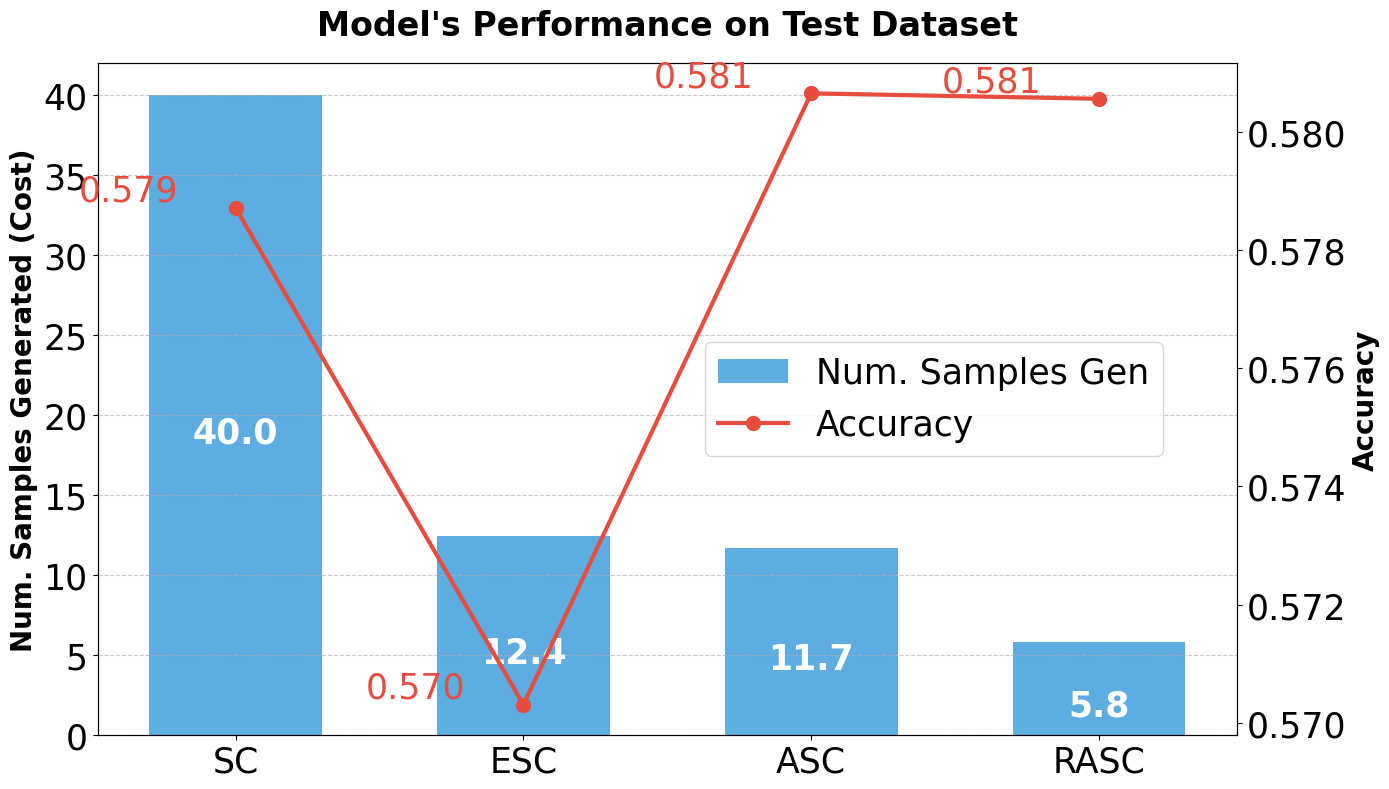

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the style for a more appealing look
sns.set_palette("deep")

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(14, 8))

# Data
methods = ['SC', 'ESC', 'ASC', 'RASC']
steps = [40, df_final_ES['ES_steps'].mean(), df_final_ES['asc_steps'].mean(), df_final_ES['CS_steps'].mean()]
accuracies = [df_final_ES['SC_correctness'].mean(), df_final_ES['ES_correctness'].mean(),
              df_final_ES['asc_correctness'].mean(), df_final_ES['CS_correctness'].mean()]

# Colors
bar_color = '#3498db'
line_color = '#e74c3c'

# Bar plot
bars = ax.bar(methods, steps, alpha=0.8, color=bar_color, width=0.6, label='Num. Samples Gen')

# Line plot
ax_twin = ax.twinx()
line = ax_twin.plot(methods, accuracies, marker='o', color=line_color, linewidth=3, markersize=10, label='Accuracy')

# Customize the plot
ax.set_ylabel('Num. Samples Generated (Cost)', fontsize=20, fontweight='bold')
ax_twin.set_ylabel('Accuracy', fontsize=20, fontweight='bold')
ax.set_title("Model's Performance on Test Dataset", fontsize=24, fontweight='bold', pad=20)

# Rotate x-axis labels for better readability
ax.set_xticklabels(methods, rotation=0, ha='center', fontsize=20)

# Add value labels on the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height/2,
            f'{height:.1f}',
            ha='center', va='top', fontsize=25, color='white', fontweight='bold')

# Add value labels for the line plot
for i, acc in enumerate(accuracies):
    ax_twin.text(i - 0.2, acc, f'{acc:.3f}', ha='right', va='bottom', fontsize=25, color=line_color)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=25)
ax_twin.tick_params(axis='y', which='major', labelsize=25)

# Add a grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Combine legends and position in middle right, slightly to the left
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax_twin.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='center right', fontsize=25, bbox_to_anchor=(0.95, 0.5))  # Updated legend position

# Adjust layout and save the plot as SVG
plt.tight_layout()
plt.savefig("TestDataset_Performance.svg", format="svg", bbox_inches="tight", dpi=300)
plt.show()



# Abalation: Human Evaluation (Table 5)

In [2]:
df_cot = pd.read_csv('../../data/CoT_data/final_train.csv')

In [3]:
feature_dict = {
    'id': [],
    'cot': [],
}

In [4]:
df_cot['Question'].isna().sum()

0

In [5]:
from tqdm import tqdm
for row in tqdm(range(len(df_cot))):
    feature_dict['id'].append(row)
    feature_dict['cot'].append([cot for cot in df_cot.iloc[row][[col for col in df_cot.columns if col.startswith('CoT_')]]])

100%|██████████| 27549/27549 [00:05<00:00, 5220.45it/s]


In [6]:
df_cot.columns

Index(['Category', 'CoT_0', 'CoT_1', 'CoT_10', 'CoT_11', 'CoT_12', 'CoT_13',
       'CoT_14', 'CoT_15', 'CoT_16',
       ...
       'Instruction Violation_39', 'Instruction Violation_4',
       'Instruction Violation_5', 'Instruction Violation_6',
       'Instruction Violation_7', 'Instruction Violation_8',
       'Instruction Violation_9', 'Model', 'Name', 'Question'],
      dtype='object', length=125)

In [7]:
CoT_df = pd.DataFrame(feature_dict)

In [8]:
CoT_df['question'] = df_cot['Question']

In [9]:
df_cot = df.merge(CoT_df, left_index=True, right_index=True)

In [10]:
df_cot[df_cot['SC_correctness'] == 1].columns

Index(['id_x', 'Name', 'Model', 'correct answer', 'CoT answers', 'Correctness',
       'SIM_INPUT', 'SIM_COT_BIGRAM', 'STEP_COHERENCE', 'IMPERATIVE_DENSITY',
       'AVG_STEP_LENGTH', 'MATH_TERM_DENSITY', 'QUA_IM', 'SIM_AC_BIGRAM',
       'LEN', 'SIM_COT_AGG', 'SIM_AC_AGG', 'STEP_COUNT', 'DIF_IV',
       'SC_correctness', 'ES_correctness', 'ES_steps', 'asc_correctness',
       'asc_steps', 'direct_acc', 'id_y', 'cot', 'question'],
      dtype='object')

In [11]:
feature_li = ['LEN', 'QUA_IM', 'SIM_COT_BIGRAM', 'SIM_COT_AGG', 'SIM_AC_BIGRAM', 'SIM_AC_AGG', 'SIM_INPUT', 'STEP_COUNT', 'STEP_COHERENCE']
df_cs,coe = trained_LR_model(df_cot, feature_li, report_auroc=False,train_mode=True)

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Train DataFrame:
Model
vicuna-13b    3698
GPT3.5        3482
GPT-4         2401
Llama2        2126
Name: count, dtype: int64
Name
GSM8K_easy             3186
common                 2531
asdiv                  1467
GSM8K_hard             1342
last_letters           1048
MathQA                  825
svamp                   700
date                    258
boolean_expressions     175
disambiguation          175
Name: count, dtype: int64

Test DataFrame:
Model
vicuna-13b    1586
GPT3.5        1493
GPT-4         1028
Llama2         911
Name: count, dtype: int64
Name
GSM8K_easy             1367
common                 1084
asdiv                   629
GSM8K_hard              575
last_letters            449
MathQA                  353
svamp                   300
date                    111
boolean_expressions      75
disambiguation           75
Name: count, dtype: int64
Optimization terminated successfully.
         Current function value: 0.543780
         Iterations 7
                          

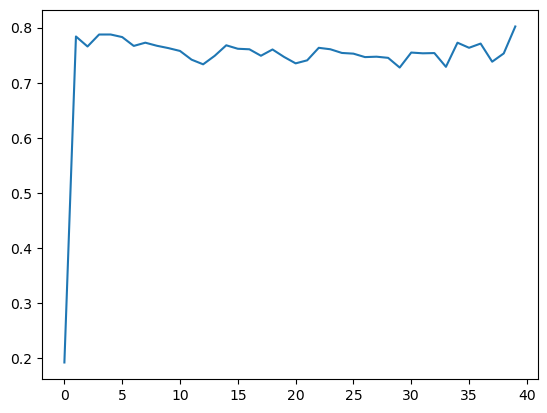

In [12]:
import matplotlib.pyplot as plt
plt.plot(df_cs['confidence_score'].iloc[0])

In [13]:
confidence_scores = [score for sublist in df_cs['confidence_score'] for score in sublist]
correctness = [label for sublist in df_cs['Correctness'] for label in sublist]

# Create a new DataFrame with the flattened data
flat_df = pd.DataFrame({
    'confidence_score': confidence_scores,
    'SC_correctness': correctness
})

# Calculate average confidence score for each correctness label
result = flat_df.groupby('SC_correctness')['confidence_score'].mean()

In [14]:
def get_cot_ranking(row):
    correctness = row['Correctness']
    confidence_scores = row['confidence_score']
    cots = row['cot']

    # Filter out the first index
    filtered_scores = [score for i, (score, correct) in enumerate(zip(confidence_scores, correctness)) if correct == 1 and i != 0]
    filtered_cots = [cot for i, (cot, correct) in enumerate(zip(cots, correctness)) if correct == 1 and i != 0]
    filtered_indices = [i for i, correct in enumerate(correctness) if correct == 1 and i != 0]  # store original indices

    # Add the number of correct answers excluding the first index
    num_correct = len(filtered_scores)

    # If no correct CoTs, return NaNs
    if not filtered_scores:
        return pd.Series({
            'best_cot': np.nan,
            'second_best_cot': np.nan,
            'worst_cot': np.nan,
            'best_cot_index': np.nan,
            'second_best_cot_index': np.nan,
            'worst_cot_index': np.nan,
            'best_cot_confidence': np.nan,
            'worst_cot_confidence': np.nan,
            'number_of_correct': num_correct
        })

    # Get sorted indices in descending order of confidence scores
    sorted_indices = np.argsort(filtered_scores)[::-1]

    best_index = sorted_indices[0]
    second_best_index = sorted_indices[1] if len(sorted_indices) > 1 else best_index
    worst_index = sorted_indices[-1]

    # Return the best, second best, and worst CoTs, their indices, their confidence scores, and the number of correct answers
    return pd.Series({
        'best_cot': filtered_cots[best_index],
        'second_best_cot': filtered_cots[second_best_index],
        'worst_cot': filtered_cots[worst_index],
        'best_cot_index': filtered_indices[best_index],
        'second_best_cot_index': filtered_indices[second_best_index],
        'worst_cot_index': filtered_indices[worst_index],
        'best_cot_confidence': filtered_scores[best_index],
        'worst_cot_confidence': filtered_scores[worst_index],
        'number_of_correct': num_correct
    })

# Apply the function to each row of the dataframe
df_cs[['best_cot', 'golden_cot', 'sc_cot', 'best_cot_index', 'second_best_cot_index', 'worst_cot_index', 'best_cot_confidence', 'worst_cot_confidence', 'number_of_correct']] = df_cs.apply(get_cot_ranking, axis=1)




In [15]:
df_cs = df_cs[df_cs['number_of_correct'] >= 3]

In [17]:
df_cs.columns

Index(['id_x', 'Name', 'Model', 'correct answer', 'CoT answers', 'Correctness',
       'SIM_INPUT', 'SIM_COT_BIGRAM', 'STEP_COHERENCE', 'IMPERATIVE_DENSITY',
       'AVG_STEP_LENGTH', 'MATH_TERM_DENSITY', 'QUA_IM', 'SIM_AC_BIGRAM',
       'LEN', 'SIM_COT_AGG', 'SIM_AC_AGG', 'STEP_COUNT', 'DIF_IV',
       'SC_correctness', 'ES_correctness', 'ES_steps', 'asc_correctness',
       'asc_steps', 'direct_acc', 'id_y', 'cot', 'question',
       'confidence_score', 'best_cot', 'golden_cot', 'sc_cot',
       'best_cot_index', 'second_best_cot_index', 'worst_cot_index',
       'best_cot_confidence', 'worst_cot_confidence', 'number_of_correct'],
      dtype='object')

In [28]:
def categorize_reasoning(category):
    if category in ['GSM8K_easy', 'asdiv', 'GSM8K_hard', 'MathQA','svamp']:
        return 'mathematical reasoning'
    elif category in ['date', 'common']:
        return 'common sense reasoning'
    else:
        return 'symbolic reasoning'

# Assuming your DataFrame is called df and the column with these categories is called 'category'
df_cs['reasoning_type'] = df_cs['Name'].apply(categorize_reasoning)

In [29]:
hard_tasks = ['boolean expressions', 'disambiguation', 'last letters', 'ruin_names', 'GSM8K_hard']
df_cs['task_difficulty'] = df_cs['Name'].apply(lambda x: 'hard' if x in hard_tasks else 'easy')

In [30]:
df_answer_best = CS_early_stopping(df=df_cs, threshold=0.5, N=3)

SC_ACC : 0.8082191780821918
ES_ACC : 0.8013698630136986
CS_ACC : 0.803213909378293
SC_Avg_Steps : 40
ES_Avg_Steps : 13.600105374077977
CS_Avg_Steps : 7.164383561643835
ASC_Avg_Steps : 11.935985247629084
ASC_ACC : 0.8063751317175974


In [35]:
df_temp = df_answer_best[(df_answer_best['CS_correctness'] == 1) & (df_answer_best['SC_correctness'] == 0)]

In [31]:
def sample_and_save(df, reasoning_type, n_samples):
    # Filter for the specific reasoning type and where the sum of 'len' list is 0
    df_filtered = df[
        (df['reasoning_type'] == reasoning_type) & 
        (df['LEN'].apply(sum) == 0) & 
        (~df['best_cot'].str.contains('def')) & 
        (~df['golden_cot'].str.contains('def')) & 
        (~df['sc_cot'].str.contains('def'))
    ]
    
    # Sample n_samples or all if fewer are available
    sampled = df_filtered.sample(n=min(n_samples, len(df_filtered)), random_state=42)
    
    # Select the required columns
    columns_to_save = ['SC_correctness', 'correct answer', 'question', 'best_cot', 'golden_cot', 'sc_cot', 'cot', 
                       'Correctness', 'confidence_score', 'Name', 'reasoning_type', 'Model', 'task_difficulty', 
                       'best_cot_index', 'second_best_cot_index', 'worst_cot_index', 'number_of_correct', 
                       'best_cot_confidence', 'worst_cot_confidence']
    sampled_subset = sampled[columns_to_save]
    
    return sampled_subset

# Sample and save for each reasoning type
mathematical_samples = sample_and_save(df_cs, 'mathematical reasoning', 100)
common_sense_samples = sample_and_save(df_cs, 'common sense reasoning', 100)
symbolic_samples = sample_and_save(df_cs, 'symbolic reasoning', 100)

# Combine all samples into one DataFrame
all_samples = pd.concat([mathematical_samples, common_sense_samples, symbolic_samples])

split_samples = [group.sample(n=min(50, len(group))) for _, group in all_samples.groupby('reasoning_type', group_keys=False)]
set1, set2 = [pd.concat(split_samples).sample(frac=1).reset_index(drop=True) for _ in range(2)]


In [34]:
set2.rename(columns= {'correct answer':'correct_answer'}, inplace=True)
set1.rename(columns= {'correct answer':'correct_answer'}, inplace=True)

In [27]:
set1.to_csv('yuqi.csv', index=False)
set2.to_csv('gy.csv', index=False)

In [28]:
all_samples.to_json('all_samples.json', orient='records', lines=True)